In [28]:
import pickle
import random
from statistics import mean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
import sqlite3

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
with open('../datafiles/pickles/affr_bow_500','rb') as affr_bow_500:
    affr_bow_500 = pickle.load(affr_bow_500).toarray()
    print(affr_bow_500.shape,affr_bow_500[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

with open('../datafiles/pickles/affr_bigram_bow_500','rb') as affr_bigram_bow_500:
    affr_bigram_bow_500 = pickle.load(affr_bigram_bow_500).toarray()
    print(affr_bigram_bow_500.shape,affr_bigram_bow_500[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

with open('../datafiles/pickles/affr_ngram_tfidf_500','rb') as affr_ngram_tfidf_500:
    affr_ngram_tfidf_500 = pickle.load(affr_ngram_tfidf_500).toarray()
    print(affr_ngram_tfidf_500.shape,affr_ngram_tfidf_500[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

with open('../datafiles/pickles/avg_w2v','rb') as avg_w2v:
    avg_w2v = np.array(pickle.load(avg_w2v))
    print(avg_w2v.shape,avg_w2v[0])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

with open('../datafiles/pickles/tdifd_weighted_w2v','rb') as tdifd_weighted_w2v:
    tdifd_weighted_w2v = np.array(pickle.load(tdifd_weighted_w2v))
    print(tdifd_weighted_w2v.shape,tdifd_weighted_w2v[0])

(364171, 500) [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 

In [3]:
conn = sqlite3.connect('../datafiles/amazon_reviews.sqlite')
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score!=3""",conn)
def scr(s):
    if(s>3):
        return 1
    else:
        return 0
data['Score'] = data['Score'].apply(scr)
cus_data = data.drop_duplicates(subset={'UserId','ProfileName', 'Time', 'Text'},keep='first')
cus_data = cus_data[cus_data['HelpfulnessNumerator']<=cus_data['HelpfulnessDenominator']]
Scr = cus_data['Score'].copy()

In [4]:
class Knn:
    def __init__(self,X,Y,time_splits=5,algorithm='auto'):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.time_splits = time_splits
        self.algorithm = algorithm

    def KNN_TS(self):
        X_train_n_cv, X_test, Y_train_n_cv, Y_test = train_test_split(self.X,self.Y,test_size=0.3,random_state=0)
        tscv = TimeSeriesSplit()
        TimeSeriesSplit(max_train_size=None, n_splits=self.time_splits)
        scrs = list()
        auroc_score = dict()
        for n in tqdm(range(1,100,2)):
            cv_fold_score = list()
            train_fold_score = list()
            auroc_fold_score = list()
            auroc_fold_score_proba = list()
            for train_index, cv_index in tqdm(tscv.split(X_train_n_cv)):
                X_train,Y_train = X_train_n_cv[train_index],Y_train_n_cv[train_index]
                X_cv,Y_cv = X_train_n_cv[cv_index],Y_train_n_cv[cv_index]
                model = KNeighborsClassifier(n_neighbors = n, algorithm = self.algorithm)  
                model.fit(X_train,Y_train)
                y_cv_pred_proba = model.predict_proba(X_cv)[:,1]
                y_cv_pred = model.predict(X_cv)
                cv_fold_score.append(model.score(X_cv,Y_cv))
                train_fold_score.append(model.score(X_train,Y_train))
                auroc_fold_proba = roc_auc_score(Y_cv,y_cv_pred_proba) 
                auroc_fold_score_proba.append(auroc_fold_proba)
                auroc_fold_score.append(roc_auc_score(Y_cv,y_cv_pred))
            scrs.append([n,mean(cv_fold_score),mean(train_fold_score),mean(auroc_fold_score),mean(auroc_fold_score_proba)])
            auroc_score[n] = mean(auroc_fold_score)
        max_roc_score = max(auroc_score.values())
        self.max_roc_score = max_roc_score
        scrs = pd.DataFrame(data = scrs,columns=['K','CV score','Train score','AUROC','AUROC with probability'])
        self.scrs = scrs
        optimal_k = max(auroc_score, key=auroc_score.get)
        return scrs,auroc_score,optimal_k

    def Plot_roc():
        pass

    def Plot_scrs(self):
        trn_err = self.scrs['Train score'].apply(lambda x: 1-x,1)
        cv_err = self.scrs['CV score'].apply(lambda x: 1-x,1)
        sns.lineplot(y='CV score',x='K',data=self.scrs)
        sns.lineplot(y='Train score',x='K',data=self.scrs)
        fig = plt.figure()
        sns.lineplot(y=cv_err,x='K',data=self.scrs)
        sns.lineplot(y=trn_err,x='K',data=self.scrs)

    def KNN_KCV(self,fold=10):
        self.X = pd.DataFrame(self.X)
        self.Y = pd.DataFrame(self.Y)
        X_train_n_cv, X_test, Y_train_n_cv, Y_test = train_test_split(self.X,self.Y,test_size=0.3,random_state=0)
        indx = list(X_train_n_cv.index)
        random.shuffle(indx)
        split = [indx[i::fold] for i in range(fold)]
        scrs = list()
        auroc_score = dict()
        for n in tqdm(range(1,100,2)):
            cv_fold_score = list()
            train_fold_score = list()
            auroc_fold_score = list()
            auroc_fold_score_proba = list()
            for j in range(1,fold+1):
                X_train  = X_train_n_cv.loc[list(set(X_train_n_cv.index)-set(split[j-1]))] 
                Y_train  = Y_train_n_cv.loc[list(set(X_train_n_cv.index)-set(split[j-1]))]
                X_cv  = X_train_n_cv.loc[split[j-1]]
                Y_cv  = Y_train_n_cv.loc[split[j-1]]
                model = KNeighborsClassifier(n_neighbors = n, algorithm = self.algorithm)
                model.fit(X_train,Y_train)
                y_cv_pred_proba = model.predict_proba(X_cv)[:,1]
                y_cv_pred = model.predict(X_cv)
                cv_fold_score.append(model.score(X_cv,Y_cv))
                train_fold_score.append(model.score(X_train,Y_train))
                auroc_fold_proba = roc_auc_score(Y_cv,y_cv_pred_proba) 
                auroc_fold_score_proba.append(auroc_fold_proba)
                auroc_fold_score.append(roc_auc_score(Y_cv,y_cv_pred))
            scrs.append([n,mean(cv_fold_score),mean(train_fold_score),mean(auroc_fold_score),mean(auroc_fold_score_proba)])
            auroc_score[n] = mean(auroc_fold_score)
        max_roc_score = max(auroc_score.values())
        self.max_roc_score = max_roc_score
        scrs = pd.DataFrame(data = scrs,columns=['K','CV score','Train score','AUROC','AUROC with probability'])
        self.scrs = scrs
        optimal_k = max(auroc_score, key=auroc_score.get)
        return scrs,auroc_score,optimal_k


In [11]:
# knn = Knn(tdifd_weighted_w2v,Scr[0:1000])
knn = Knn(avg_w2v[11000:13000],Scr[11000:13000])

In [2]:
scores,auc,ok = knn.KNN_TS()

NameError: name 'knn' is not defined

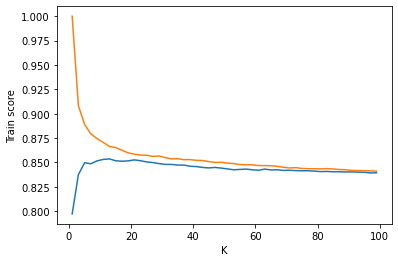

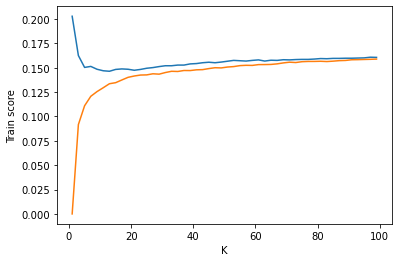

In [11]:
knn.Plot_scrs()

In [12]:
 scores,auc,ok = knn.KNN_KCV()

100%|██████████| 50/50 [02:00<00:00,  2.40s/it]


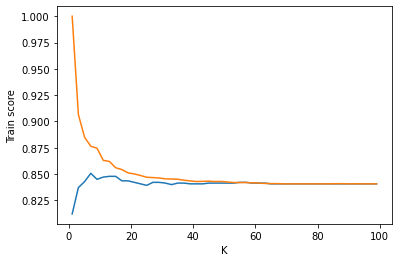

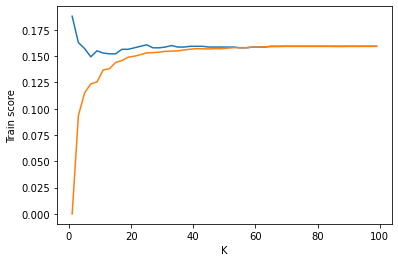

In [14]:
knn.Plot_scrs()

In [16]:
scores,auc,ok = knn.KNN_KCV(5)

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


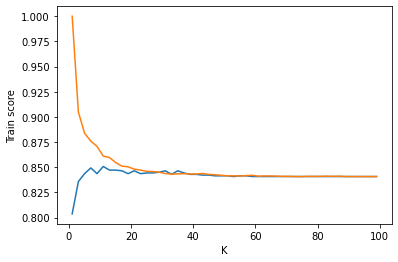

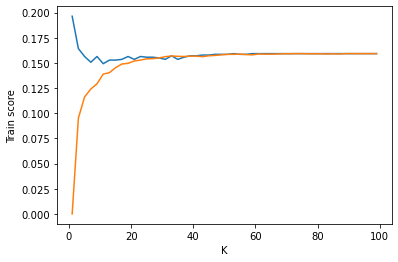

In [17]:
knn.Plot_scrs()

In [18]:
scores,auc,ok = knn.KNN_KCV(20)

100%|██████████| 50/50 [03:55<00:00,  4.72s/it]


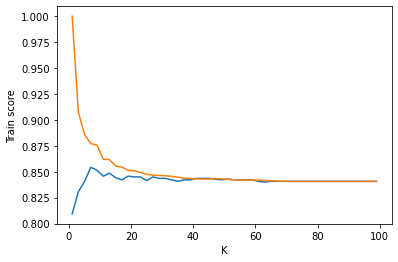

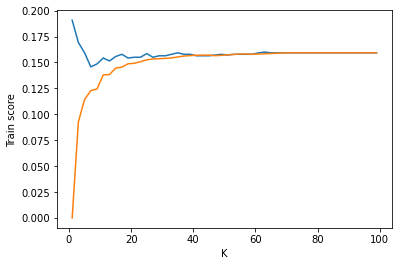

In [20]:
knn.Plot_scrs()

In [27]:
clf = GridSearchCV(estimator=KNeighborsClassifier(),param_grid={'n_neighbors':[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3]})
clf.fit(avg_w2v[11000:13000],Scr[11000:13000])

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                         1000]})

In [34]:
for i in tqdm([1,10**1,10**2,10**3]):
    cvscr = cross_val_score(KNeighborsClassifier(i),avg_w2v[10000:20000],Scr[10000:20000],cv=5)
    print(cvscr.mean())

100%|██████████| 4/4 [00:37<00:00,  9.26s/it]0.8428000000000001



In [35]:
k_lst = range(1,1000,100)
for i in tqdm(k_lst):
    cvscr = cross_val_score(KNeighborsClassifier(i),avg_w2v[10000:20000],Scr[10000:20000],cv=5)
    print(cvscr.mean())

100%|██████████| 10/10 [02:05<00:00, 12.50s/it]0.8428000000000001



In [36]:
for i in tqdm([1,10**1,10**2,10**3]):
    cvscr = cross_val_score(KNeighborsClassifier(i),affr_bow_500[10000:15000],Scr[10000:15000],cv=5)
    print(cvscr.mean())

100%|██████████| 4/4 [03:56<00:00, 59.13s/it]0.8497999999999999



In [41]:
k_lst = range(1,400,50)
for i in tqdm(k_lst):
    cvscr = cross_val_score(KNeighborsClassifier(i),avg_w2v[10000:13000],Scr[10000:13000],cv=5)
    print(cvscr.mean())

100%|██████████| 8/8 [00:26<00:00,  3.31s/it]0.8400000000000001



In [42]:
for i in tqdm([1,10**1,10**2,10**3]):
    cvscr = cross_val_score(KNeighborsClassifier(i),affr_ngram_tfidf_500[10000:20000],Scr[10000:20000],cv=5)
    print(cvscr.mean())

100%|██████████| 4/4 [16:33<00:00, 248.47s/it]0.8428000000000001



In [43]:
k_lst = range(1,400,50)
for i in tqdm(k_lst):
    cvscr = cross_val_score(KNeighborsClassifier(i),affr_ngram_tfidf_500[10000:13000],Scr[10000:13000],cv=5)
    print(cvscr.mean())

100%|██████████| 8/8 [03:01<00:00, 22.67s/it]0.8400000000000001

